In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

### Data Processing

In [264]:
scaler = StandardScaler()

In [265]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [266]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [267]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [268]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [300]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [270]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)
df_train_target = df_train[['Class']].head(100).to_numpy()
df_train_features = df_features.head(100).to_numpy()

df_test_target = df_train[['Class']].tail(100).to_numpy()
df_test_features = df_features.tail(100).to_numpy()

In [190]:
D = df_train_features.shape[1]
N = df_train_features.shape[0]
n_cat = 11 

### Ancestral Sampling 

In [192]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N,n_cat))
for n in range(N):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y[n,:])

beta: [ 0.82503249 -0.08263999 -0.6650816   1.00521237 -0.81343232  0.03856568
  0.11729303 -1.92825054  1.40766054 -1.88007472  1.54213995  0.83697542
  0.78763382 -0.48878326]
n, p and y  0 [1.93192966e-03 1.51287678e-03 7.11512814e-01 7.53469294e-05
 1.18437618e-06 1.49246388e-01 1.93219446e-04 2.05663467e-03
 1.91292611e-02 1.14339763e-01 5.81936245e-07] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
n, p and y  1 [0.0061985  0.18496162 0.00146467 0.00841234 0.01207704 0.01107422
 0.14223821 0.24955147 0.00496232 0.37847702 0.00058257] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
n, p and y  2 [3.56963472e-04 6.15027697e-04 5.52265405e-03 7.29885890e-05
 1.02544600e-03 7.28115084e-03 1.59862962e-03 1.71969077e-03
 7.76637079e-04 9.79857660e-01 1.17315190e-03] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
n, p and y  3 [1.64408094e-02 5.61732414e-01 7.01492579e-02 2.79343659e-02
 8.61027200e-05 7.74232388e-04 1.63758580e-02 1.40436679e-03
 2.95068893e-01 1.58116551e-04 9.87558327e-03] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

In [194]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))
label_array

array([ 2.,  1.,  9.,  1.,  4.,  7.,  1.,  7.,  1.,  5.,  4.,  6.,  5.,
       10.,  9.,  9.,  5.,  5.,  6.,  1.,  7.,  2.,  2.,  1.,  7., 10.,
        1.,  9.,  9.,  8.,  1.,  5.,  6.,  2.,  8.,  5.,  9.,  0.,  0.,
        5.,  1.,  7.,  7.,  2.,  2.,  1.,  5.,  2.,  9.,  1., 10.,  9.,
        2.,  1.,  9.,  3.,  5., 10.,  5., 10.,  7.,  4.,  7.,  9.,  2.,
        5.,  9.,  2.,  7.,  2.,  7.,  2.,  7.,  8.,  7.,  8.,  1.,  1.,
        6.,  9.,  3.,  7.,  1., 10.,  9.,  9.,  9.,  7., 10.,  5.,  7.,
       10.,  5.,  7.,  3.,  9.,  5.,  5.,  2.,  5.])

In [195]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({2.0: 13,
         1.0: 15,
         9.0: 16,
         4.0: 3,
         7.0: 16,
         5.0: 16,
         6.0: 4,
         10.0: 8,
         8.0: 4,
         0.0: 2,
         3.0: 3})

In [196]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.05


### Model implementation with Pyro

In [186]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [205]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Model training 

In [212]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1315.7
[1000] ELBO: 709.6
[2000] ELBO: 506.5
[3000] ELBO: 387.2
[4000] ELBO: 366.5
[5000] ELBO: 340.6
[6000] ELBO: 336.6
[7000] ELBO: 332.6
[8000] ELBO: 309.4
[9000] ELBO: 302.6
[10000] ELBO: 303.3
[11000] ELBO: 334.7
[12000] ELBO: 297.5
[13000] ELBO: 290.9
[14000] ELBO: 293.9
[15000] ELBO: 297.9
[16000] ELBO: 298.4
[17000] ELBO: 280.1
[18000] ELBO: 283.8
[19000] ELBO: 313.1


In [214]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train)

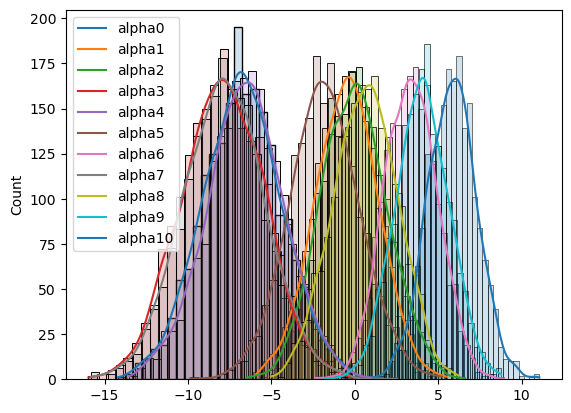

In [215]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

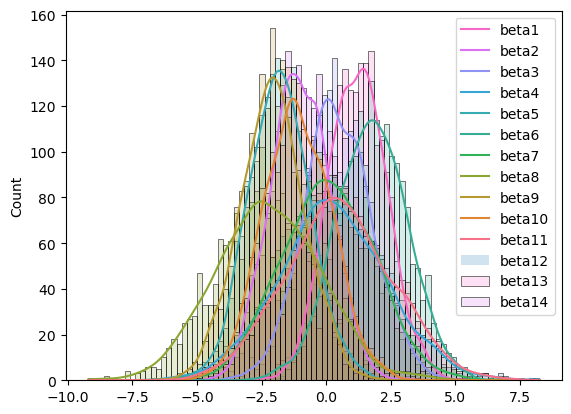

In [225]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [282]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

### Inference and computation of accuracy on the train dataset 

In [296]:
# sample observations (y's)
y_train_pred = np.zeros((N,n_cat))
for n in range(N):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_train_pred[n,:][0])

n, p and y  0 [1.42933773e-11 3.16794977e-08 7.71734642e-09 2.07911954e-13
 3.45303317e-09 9.99999935e-01 9.08372189e-09 3.03998267e-14
 2.49655753e-10 8.58113263e-09 4.31412510e-09] 5.0
n, p and y  1 [2.38229712e-06 5.11621656e-02 2.14881647e-02 5.45682661e-07
 2.72733571e-04 1.60861438e-08 1.76279902e-03 1.76861437e-08
 3.04323368e-05 2.39933301e-08 9.25280719e-01] 10.0
n, p and y  2 [7.08016546e-01 9.01989198e-03 1.27952045e-03 2.80950739e-01
 2.14235855e-05 2.32727395e-09 6.27901783e-04 4.20476117e-05
 1.97659626e-05 2.21479217e-05 1.36419172e-08] 0.0
n, p and y  3 [4.20116059e-11 5.74614673e-12 5.46209405e-11 4.69643236e-09
 7.48697390e-07 9.99517197e-01 3.29090445e-10 4.67354201e-08
 6.01075756e-08 4.81942137e-04 5.92867004e-10] 5.0
n, p and y  4 [4.40105626e-04 9.96092775e-01 3.69494835e-13 2.02616493e-11
 1.55709839e-09 3.28535871e-12 1.68583548e-06 3.16987080e-12
 2.07193247e-03 2.09961087e-14 1.39349921e-03] 1.0
n, p and y  5 [1.81058065e-03 2.83052341e-02 1.60394427e-09 7.47

In [297]:
y_train_pred = y_train_pred[:,0]

In [299]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.56


### Inference and computation of accuracy on the test dataset 

In [284]:
# sample observations (y's)
y = np.zeros((N,n_cat))
for n in range(N):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y[n,:])

n, p and y  0 [2.12912646e-04 7.34832685e-04 1.03873343e-03 6.06710995e-05
 6.30036166e-02 3.62102420e-01 5.54619595e-04 1.58706309e-04
 9.81493962e-02 5.85824611e-03 4.68125846e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  1 [7.68356337e-04 8.41132339e-01 8.63832668e-07 1.54390403e-04
 8.84186759e-03 4.66012015e-02 1.03177528e-03 2.03517683e-08
 1.00393394e-01 1.66779911e-05 1.05911335e-03] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
n, p and y  2 [2.59198616e-07 3.93922558e-03 2.79095212e-03 2.60950444e-07
 8.14401060e-04 6.38885967e-06 1.65193831e-02 3.27458238e-08
 3.83927977e-03 2.55108806e-05 9.72064306e-01] [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
n, p and y  3 [1.06313148e-07 9.09479680e-13 9.48274736e-11 4.79477278e-05
 4.16496077e-07 1.20064720e-26 2.34201424e-16 9.99951529e-01
 4.06355255e-23 1.75683843e-11 2.16832162e-17] [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
n, p and y  4 [1.26890367e-06 2.33019017e-03 1.32634305e-09 4.31466662e-08
 4.65364701e-07 3.67578469e-04 

In [289]:
print("Accuracy:", 1.0*np.sum(y == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.33
